Last edited by Clare Huang on March 20, 2018.

# Hanning window
This tutorial is about smoothing noisy signals by applying the Hanning window function in SciPy package. The documentation can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hanning.html). For an introduction of windowing, you may find the following article useful: ['Understanding FFT and windowing'](http://download.ni.com/evaluation/pxi/Understanding%20FFTs%20and%20Windowing.pdf), [wikipedia: window function](https://en.wikipedia.org/wiki/Window_function).


In [1]:
import numpy as np
from scipy.signal import hanning
import datetime
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift, fftfreq

# Example: temperature data from a weather station in Chicago
- The temperature data is available at: [https://climexp.knmi.nl/data/vgdcnUSC00111497.dat](https://climexp.knmi.nl/data/vgdcnUSC00111497.dat)
- It is downloaded and saved as ```data/vgdcnUSC00111497.txt```.
- The four columns respectively refers to:
    1. Year
    2. Month
    3. Date
    4. Average of minimum and maximum temperature

In [2]:
data = np.loadtxt('data/vgdcnUSC00111497.txt', skiprows=18)
print(data.shape) # Shape of the data

(12940, 4)


In [3]:
# Let's only look at a year of data
N = 365 * 30 # number of sample (take 30 years here)
temperature_last_year = data[-N:,-1]

In [4]:
init_year, init_month, init_day = data[-N,:3]

date_array = [datetime.date(int(init_year), int(init_month), int(init_day)) 
              + i*datetime.timedelta(days=1) for i in range(N)]

# Visualize the time series data

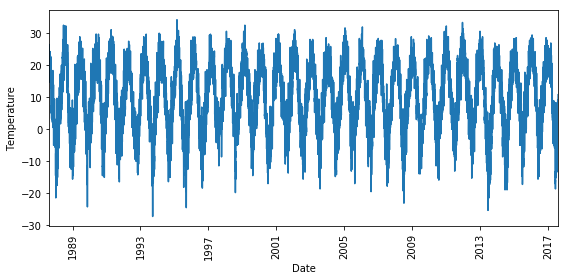

In [5]:
plt.figure(figsize=(8,4))
plt.plot(date_array,temperature_last_year)
plt.xlabel('Date')
plt.xlim((date_array[0],date_array[-1]))
plt.xticks(rotation=90)
plt.ylabel('Temperature')
plt.tight_layout()
plt.show()

In [6]:
T = 1./N
xf = fftfreq(N, d=1.0) # sample frequency is cycle/day
ck = fft(temperature_last_year)
print('size of Fourier coeffient array =', ck.size)

size of Fourier coeffient array = 10950


# Visualize the Fourier coefficients as a function of frequency [cycle/day]
- The function ```fftshift``` sort the frequency in ascending order such that you don't have to sort it manually. (See [documentation of fftshift](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.fftpack.fftshift.html).)

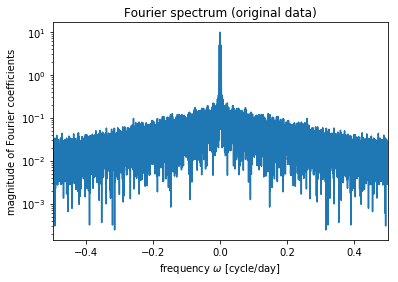

In [7]:
plt.semilogy(fftshift(xf), np.abs(fftshift(ck)/N)) # Take the absolute value. 
plt.title('Fourier spectrum (original data)')
plt.xlabel('frequency $\omega$ [cycle/day]');
plt.ylabel('magnitude of Fourier coefficients');
plt.xlim((xf.min(),xf.max()))
plt.show()

# Load Hanning window from SciPy
Documentation of Hanning window: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hanning.html

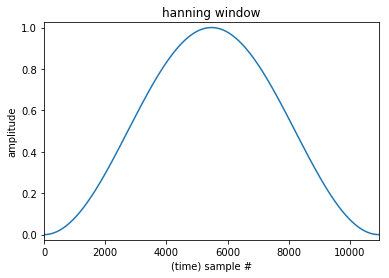

In [8]:
from scipy.signal import get_window

w = get_window('hann', N)

plt.plot(np.arange(N), w)
plt.xlabel("(time) sample #")
plt.ylabel("amplitude")
plt.title("hanning window")
plt.xlim(0, N-1)
plt.ylim(-0.025, 1.025)
plt.show()

# Apply the Hanning window on the temperature data (with window size equal to the length of the temperature array)

/home/csyhuang/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


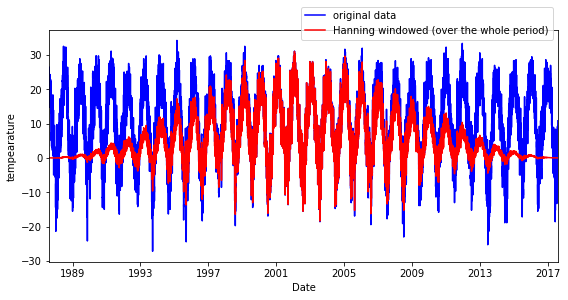

In [9]:
ywf = 1/N * fft(temperature_last_year * w)
temperature_last_year_windowed = ifft((N* ywf))

plt.figure(figsize=(8,4))
plt.plot(date_array,temperature_last_year,'b-',label='original data')
plt.plot(date_array,temperature_last_year_windowed,'r-',label='Hanning windowed (over the whole period)')
plt.xlim((date_array[0],date_array[-1]))
plt.xlabel('Date')
plt.ylabel('tempearature')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102))
plt.tight_layout()
plt.show()

# Examine the power (square of magnitude) of Fourier spectra 
- The original data (left) and Hanning-windowed data (right)
- A peak at the period 365 is observed in the lower panel (with frequency as the x-axis), corresponding to the yearly seasonal cycle.

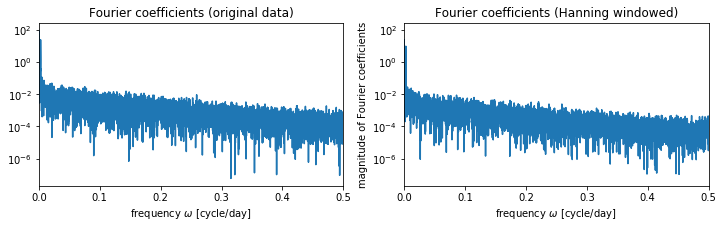

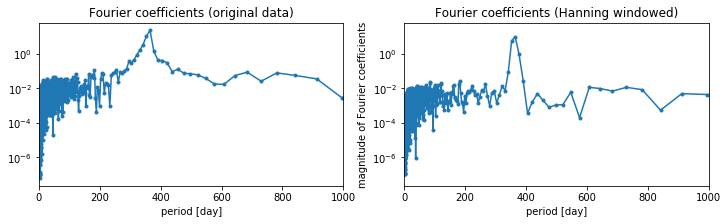

In [10]:
ywf = 1/N * fft(temperature_last_year * w)

# Using frequency as the x-axis
plt.subplots(figsize=(12,3))

ax1 = plt.subplot(122)
ax1.semilogy(fftshift(xf), np.abs(fftshift(ywf))**2, label='Hanning windowed') # Take the absolute value. 
ax1.set_title('Fourier coefficients (Hanning windowed)')
ax1.set_xlabel('frequency $\omega$ [cycle/day]');
ax1.set_ylabel('magnitude of Fourier coefficients');
ax1.set_xlim((0,xf.max()))

ax2 = plt.subplot(121, sharey=ax1)
ax2.semilogy(fftshift(xf), np.abs(fftshift(ck)/N)**2, label='Original data') # Take the absolute value. 
ax2.set_xlim((0,xf.max()))
ax2.set_title('Fourier coefficients (original data)')
ax2.set_xlabel('frequency $\omega$ [cycle/day]');

plt.show()

# Using period as the x-axis
plt.subplots(figsize=(12,3))

ax3 = plt.subplot(122)
ax3.plot(1./xf[1:], np.abs(ywf[1:])**2, '.-', label='Hanning windowed') # Take the absolute value. 
ax3.set_yscale('log')
ax3.set_title('Fourier coefficients (Hanning windowed)')
ax3.set_xlabel('period [day]');
ax3.set_ylabel('magnitude of Fourier coefficients');
ax3.set_xlim((0,1000))

ax4 = plt.subplot(121, sharey=ax3)
ax4.semilogy(1./xf[1:], np.abs(ck[1:]/N)**2, '.-', label='Original data') # Take the absolute value. 
ax4.set_yscale("log")
ax4.set_title('Fourier coefficients (original data)')
ax4.set_xlabel('period [day]');
ax4.set_xlim((0,1000))

plt.show()

# Obtain the power spectrum (i.e. square of coefficient magnitude) of the signal

The example above only apply Hanning window to the entire time series once. You can apply the windows at different segments of the time series and average their spectra to obtain a smoother spectrum. This can be done using the function ```scipy.signal.csd``` which applies the [Welch's Method](https://en.wikipedia.org/wiki/Welch%27s_method) to reduce noise in the series by windowing different segments in the time series:

https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.csd.html



## Sanity check
Below is a comparison of power spectra obtained by using ```csd``` and ```fft``` *without* windowing.
(Note: there is a difference in the magnitudes of the spectra, but the characteristic looks similar. **TODO: check the documentations of the two functions.**)

## Parameters in ```csd```
- fs: sampling frequency. Here, the sampling frequency is 1 per day.
- window: the name of the window, or an array specifying the weight of the window
- nperseg: length of the window, which, if you specify the window with an array, it shall match the length of the array

Check the [documentation](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.csd.html) of ```csd``` about the parameters.

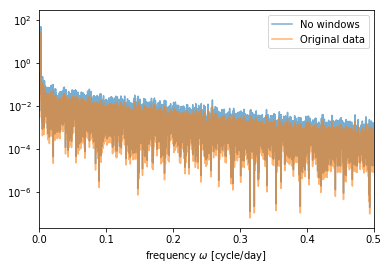

In [11]:
from scipy.signal import csd

freq, power_spec = csd(temperature_last_year,temperature_last_year, fs=1, 
                       window=np.ones((len(temperature_last_year))), 
                       nperseg=len(temperature_last_year),
                       scaling='spectrum')

plt.semilogy(freq[1:], power_spec[1:], label='No windows', alpha = 0.6)
plt.semilogy(fftshift(xf), np.abs(fftshift(ck)/N)**2, label='Original data', alpha = 0.6)
plt.xlabel('frequency $\omega$ [cycle/day]');
plt.legend()
plt.xlim((0,0.5))
plt.show()


## Comparing the effects of Hanning window with different window size
Here is a comparison of time series filtered by Hanning window of different sizes using the function ```csd```. Note the trade-off between getting a smoother spectrum and getting spectral details. Think about what you would like to find out with the plot, and choose the right range of parameters to test with.

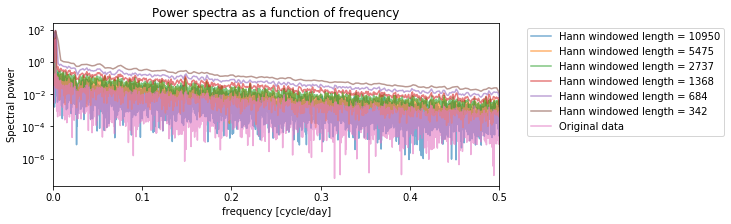

/home/csyhuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


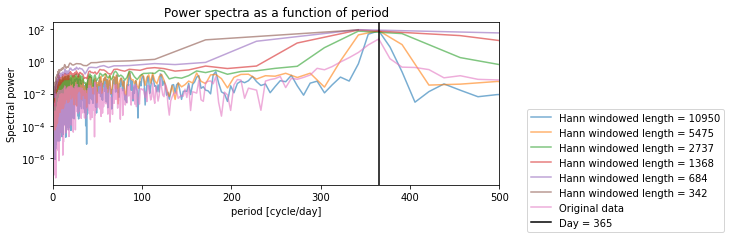

In [12]:
# Frequency as x-axis
plt.figure(figsize=(8,3))
for window_length in [N//2**i for i in range(6)]:
    freq, power_spec = csd(temperature_last_year,temperature_last_year, fs=1, 
                           window='hann', 
                           nperseg=window_length, scaling='spectrum')

    plt.semilogy(freq[1:], power_spec[1:], label='Hann windowed length = '+str(window_length), alpha = 0.6)
plt.semilogy(fftshift(xf), np.abs(fftshift(ck)/N)**2, label='Original data', alpha = 0.6)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title('Power spectra as a function of frequency')
plt.xlabel('frequency [cycle/day]');
plt.ylabel('Spectral power')
plt.xlim((0,0.5))
plt.show()

# Period in as x-axis
plt.figure(figsize=(8,3))
for window_length in [N//2**i for i in range(6)]:
    freq, power_spec = csd(temperature_last_year,temperature_last_year, fs=1, 
                           window='hann', 
                           nperseg=window_length, scaling='spectrum')

    plt.semilogy(1./freq[1:], power_spec[1:], label='Hann windowed length = '+str(window_length), alpha = 0.6)
plt.semilogy(fftshift(1./xf), np.abs(fftshift(ck)/N)**2, label='Original data', alpha = 0.6)
plt.axvline(x=365, c='k', label='Day = 365')
plt.legend(bbox_to_anchor=(1.05,0.5))
plt.title('Power spectra as a function of period')
plt.xlabel('period [cycle/day]');
plt.ylabel('Spectral power')
plt.xlim((0,500))
plt.show()
